In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy as sp

In [2]:
dataset = '42_slide_tag_human_skin_melanoma'

In [3]:
adata = sc.read_10x_mtx(f'../../data/reference_data/{dataset}')
adata

AnnData object with n_obs × n_vars = 6466 × 36601
    var: 'gene_ids', 'feature_types'

In [4]:
adata.obs_names

Index(['AAACCCACAACTGGTT-1', 'AAACCCACATCTCCCA-1', 'AAACCCACATGCAGCC-1',
       'AAACCCAGTCTTACTT-1', 'AAACCCAGTGGTGATG-1', 'AAACCCATCACCTTGC-1',
       'AAACGAAAGACGGAAA-1', 'AAACGAAAGATACAGT-1', 'AAACGAAAGCATACTC-1',
       'AAACGAAAGGAGAGTA-1',
       ...
       'TTTGGTTTCTTCTTCC-1', 'TTTGTTGAGAAACTAC-1', 'TTTGTTGAGACCAGCA-1',
       'TTTGTTGAGAGTCTGG-1', 'TTTGTTGCATAGGAGC-1', 'TTTGTTGGTAGTTACC-1',
       'TTTGTTGTCAGATTGC-1', 'TTTGTTGTCTATGCCC-1', 'TTTGTTGTCTCCCATG-1',
       'TTTGTTGTCTCCCTAG-1'],
      dtype='object', length=6466)

In [5]:
df = pd.read_csv(f'../../data/reference_data/{dataset}/HumanMelanomaRNA_spatial.csv', skiprows=1)
df = df.set_index('TYPE')
df.columns = ['spatial1', 'spatial2', 'cell_type']

In [6]:
df.head()

,spatial1,spatial2,cell_type
TYPE,,,
AAACCCACAACTGGTT-1,538.797277,2564.852894,CD8_T
AAACCCACATCTCCCA-1,1649.425045,1872.586045,tumour_1
AAACCCACATGCAGCC-1,2161.298833,1752.448815,T_reg
AAACCCAGTCTTACTT-1,2187.122941,1780.332588,CD8_T
AAACCCATCACCTTGC-1,2638.192990,2236.855050,CD4_T


In [7]:
sel_cells = list(set(df.index) & set(adata.obs_names))

In [8]:
len(sel_cells)

4804

In [9]:
df = df.loc[sel_cells, ]
adata = adata[sel_cells, ]

In [10]:
adata.obs = df
adata.obsm['spatial'] = df[['spatial2', 'spatial1']].values

In [11]:
sc.pp.calculate_qc_metrics(adata, inplace=True)

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=50)

In [13]:
adata

AnnData object with n_obs × n_vars = 4804 × 15637
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    obsm: 'spatial'

In [14]:
adata.layers['counts'] = adata.X.copy()

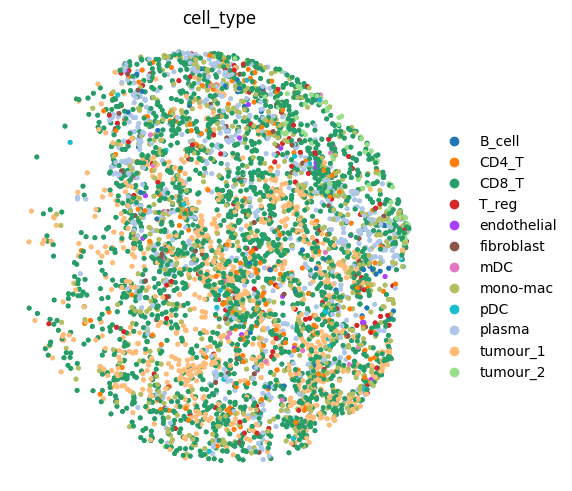

In [15]:
sq.pl.spatial_scatter(adata, color=['cell_type'], shape=None, frameon=False)

In [16]:
# remove MT genes
non_mito_genes_list = [name for name in adata.var_names if not name.startswith('MT-')]
adata = adata[:, non_mito_genes_list]

In [17]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [18]:
adata

AnnData object with n_obs × n_vars = 4804 × 15624
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'log1p'
    obsm: 'spatial'
    layers: 'counts'

In [19]:
sq.gr.spatial_neighbors(adata, coord_type="grid", delaunay=False)
sq.gr.spatial_autocorr(adata, mode="moran", 
                       n_perms=100, n_jobs=10, 
                       genes=adata.var_names)

100%|██████████| 100/100 [00:30<00:00,  3.26/s]


In [20]:
adata.uns["moranI"]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
CDH19,0.226276,0.000000,0.000118,0.000000,0.009901,0.000084,0.000000,0.000000,0.057829
LHFPL3-AS1,0.219747,0.000000,0.000118,0.000000,0.009901,0.000094,0.000000,0.000000,0.057829
AC098829.1,0.206790,0.000000,0.000118,0.000000,0.009901,0.000080,0.000000,0.000000,0.057829
CPEB2,0.206452,0.000000,0.000118,0.000000,0.009901,0.000087,0.000000,0.000000,0.057829
MAGI2,0.204987,0.000000,0.000118,0.000000,0.009901,0.000109,0.000000,0.000000,0.057829
...,...,...,...,...,...,...,...,...,...
TTC39B,-0.029567,0.003498,0.000118,0.000370,0.009901,0.000077,0.035538,0.003294,0.057829
SPIN1,-0.029964,0.003133,0.000118,0.000293,0.009901,0.000077,0.032853,0.002676,0.057829
ACAD11,-0.030065,0.003046,0.000118,0.000144,0.009901,0.000072,0.032199,0.001443,0.057829
MLH3,-0.031975,0.001760,0.000118,0.000099,0.009901,0.000071,0.020778,0.001038,0.057829


In [21]:
n_svgs = 50
sel_genes = (
    adata.uns["moranI"]["I"].sort_values(ascending=False).head(n_svgs).index.tolist()
)

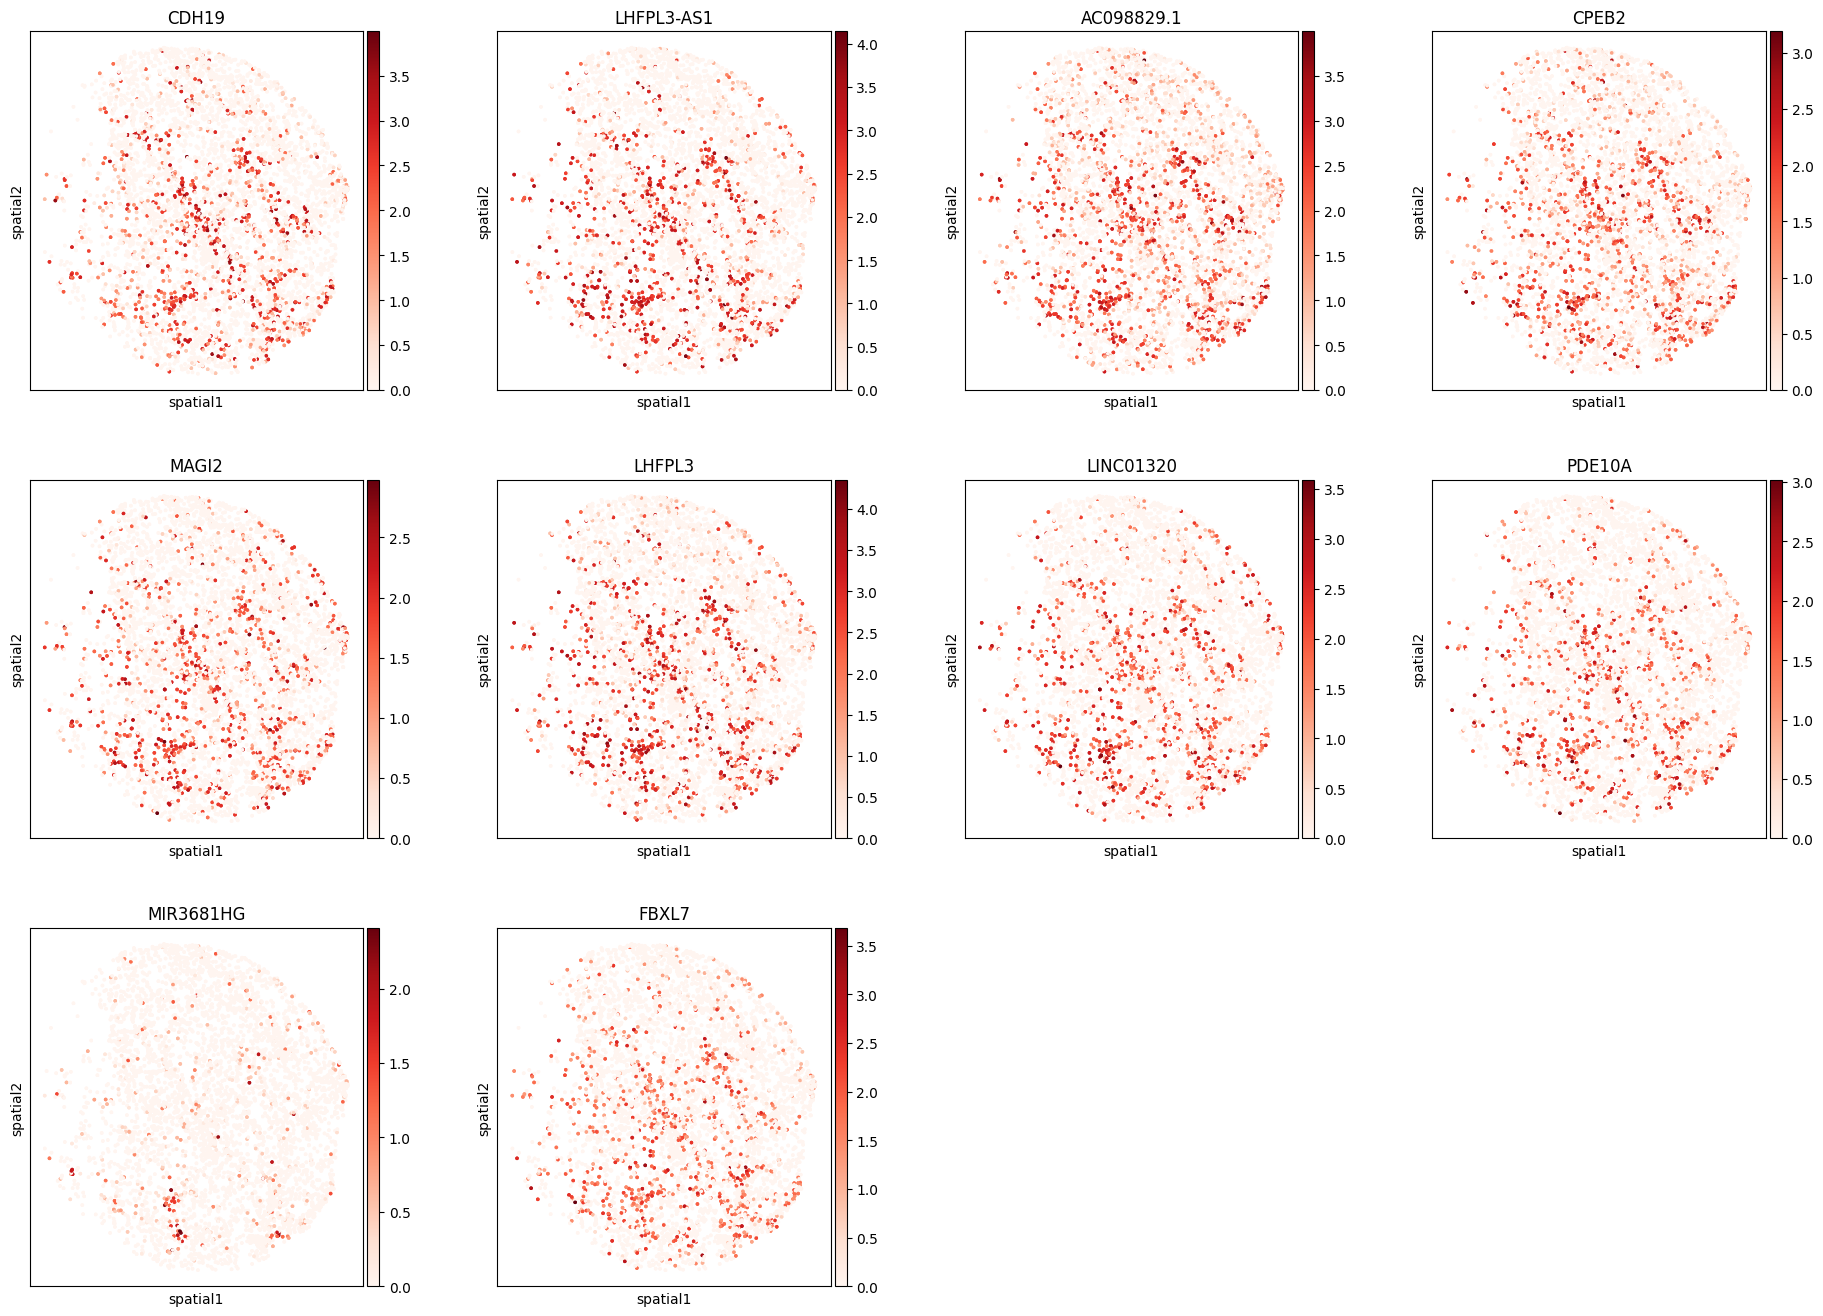

In [22]:
sq.pl.spatial_scatter(
    adata, color=sel_genes[:10], figsize=(5, 5), size=10, 
    cmap="Reds", shape=None,
)

In [23]:
# select top 50 variable genes as reference
adata = adata[:, sel_genes]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 4804 × 50
    obs: 'spatial1', 'spatial2', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'cell_type_colors', 'log1p', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    layers: 'counts'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [25]:
adata.write_h5ad(f'../../results/00_prepare_reference_data/{dataset}.h5ad')